# Breakeven Curves

This notebook generates curves that show the price points where various systems become profitable in power only or hydrogen generation mode.

## Generate Surrogates and Boilerplate

In [1]:
from util.surrogate import SurrogateProcessModels
from util.data import get_model_data
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
surrogate = SurrogateProcessModels()
surrogate.generate_surrogate_models()

In [3]:
solver_obj = pyo.SolverFactory("ipopt")

In [4]:
plot_dir = "../breakeven_plots"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Power Only

In [5]:
model0 = surrogate.single_point_model("model0", "power_only", el_price=71.70, ng_price=4.42)
model1 = surrogate.single_point_model("model1", "power_only", el_price=71.70, ng_price=4.42)
model3 = surrogate.single_point_model("model3", "power_only", el_price=71.70, ng_price=4.42)
model4 = surrogate.single_point_model("model4", "power_only", el_price=71.70, ng_price=4.42)
model5 = surrogate.single_point_model("model5", "power_only", el_price=71.70, ng_price=4.42)

all_models = [model0, model1, model3, model4, model5]

for m in all_models:
    m.net_power.fix(m.net_power.ub)
    m.profit.fix(0) # this is breakeven point
    m.ng_price.unfix()

Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (200.0, 650.0).
Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (200.0, 650.0).
Setting bound of net_power to (219.07692307692307, 712.0).


In [6]:
el_price_vec = np.linspace(20, 120, 30)

model0_ng_price_vec = []
model1_ng_price_vec = []
model4_ng_price_vec = []
model3_ng_price_vec = []
model5_ng_price_vec = []

for el_price in el_price_vec:
    for m in all_models:
        m.el_price.fix(el_price)
        res = solver_obj.solve(m)
        
    model0_ng_price_vec.append(pyo.value(model0.ng_price))
    model1_ng_price_vec.append(pyo.value(model1.ng_price))
    model4_ng_price_vec.append(pyo.value(model4.ng_price))
    model3_ng_price_vec.append(pyo.value(model3.ng_price))
    model5_ng_price_vec.append(pyo.value(model5.ng_price))

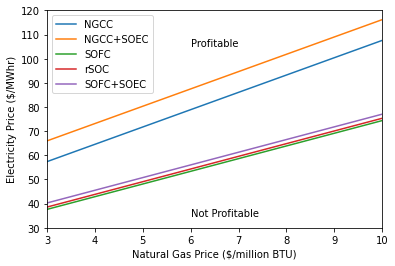

In [7]:
plot_file = os.path.join(plot_dir, "breakeven_power_only.png")
plt.plot(model0_ng_price_vec, el_price_vec, label="NGCC")
plt.plot(model3_ng_price_vec, el_price_vec, label="NGCC+SOEC")
plt.plot(model1_ng_price_vec, el_price_vec, label="SOFC")
plt.plot(model4_ng_price_vec, el_price_vec, label="rSOC")
plt.plot(model5_ng_price_vec, el_price_vec, label="SOFC+SOEC")
plt.xlim(3, 10.0)
plt.ylim(30, 120.0)
plt.legend()
plt.ylabel("Electricity Price ($/MWhr)")
plt.xlabel("Natural Gas Price ($/million BTU)")
plt.text(6, 35, "Not Profitable")
plt.text(6, 105, "Profitable")
plt.savefig(plot_file, dpi=160, bbox_inches="tight")
plt.show()

## Power and Hydrogen

In [8]:
model0 = surrogate.single_point_model("model0", "power_only", el_price=71.70, ng_price=4.42)
model1 = surrogate.single_point_model("model1", "power_only", el_price=71.70, ng_price=4.42)
model3a = surrogate.single_point_model("model3", "power_only", el_price=71.70, ng_price=4.42)
model3b = surrogate.single_point_model("model3", "hydrogen", el_price=71.70, ng_price=4.42)
model4a = surrogate.single_point_model("model4", "power_only", el_price=71.70, ng_price=4.42)
model4b = surrogate.single_point_model("model4", "hydrogen_only", el_price=71.70, ng_price=4.42)
model5a = surrogate.single_point_model("model5", "power_only", el_price=71.70, ng_price=4.42)
model5b = surrogate.single_point_model("model5", "hydrogen", el_price=71.70, ng_price=4.42)
model6 = surrogate.single_point_model("model6", "hydrogen_only", el_price=71.70, ng_price=4.42)

all_models = [model0, model1, model3a, model3b, model4a, model4b, model5a, model5b, model6]
power_models = [model0, model1, model3a, model4a, model5a]
hydrogen_models = [model3b, model4b, model5b, model6]

for m in all_models:
    m.profit.fix(0)
    
for m in power_models:
    m.net_power.fix(m.net_power.ub)
    m.el_price.unfix()

for m in hydrogen_models:
    try:
        m.net_power.unfix()
    except AttributeError:
        # 4b and 6 don't produce power and use
        # electricity cost instead
        pass 
    m.h2_price.unfix()
    m.h_prod.unfix()
    
model3b.obj2 = pyo.Objective(expr=model3b.h2_price)
model3b.obj.deactivate()
model4b.obj2 = pyo.Objective(expr=model4b.h2_price)
model4b.obj.deactivate()
model5b.obj2 = pyo.Objective(expr=model5b.h2_price)
model5b.obj.deactivate()
model6.obj2 = pyo.Objective(expr=model6.h2_price)
model6.obj.deactivate()

Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (200.0, 650.0).
Setting bound of net_power to (160.0, 650.0).
Setting bound of net_power to (-78.4122027155605, 508.793449280259).
Setting bound of h_prod to (1.00004960563519, 4.7502356267672).
Setting bound of net_power to (200.0, 650.0).
Setting bound of h_prod to (1.75, 5.0).
Setting bound of net_power to (219.07692307692307, 712.0).
Setting bound of net_power to (-378.391, 546.7495).
Setting bound of h_prod to (1.0, 5.0).
Setting bound of h_prod to (1.0, 5.0).


NG Price = 4.42


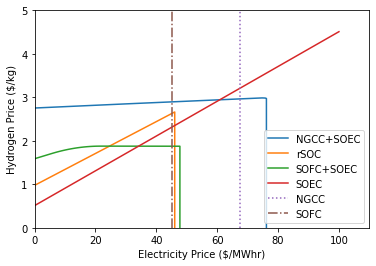

NG Price = 8.0


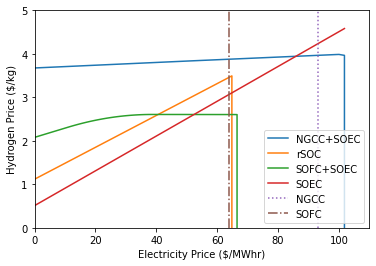

In [9]:
ng_prices = [4.42, 8.0]

for fig_no, ng_price in enumerate(ng_prices):
    # Need to be able to switch to power only mode, so need to calculate the
    # breakeven elecricity price in power only mode
    
    for m in all_models:
        m.ng_price.fix(ng_price)
        res = solver_obj.solve(m)

    model0_el_price_point = pyo.value(model0.el_price)
    model1_el_price_point = pyo.value(model1.el_price)
    model3_el_price_point = pyo.value(model3a.el_price)
    model4_el_price_point = pyo.value(model4a.el_price)
    model5_el_price_point = pyo.value(model5a.el_price)
    

    el_price_vec = np.linspace(0, 100, 100)
    pp = np.array(sorted([model3_el_price_point, model4_el_price_point, model5_el_price_point]))
    idx = np.searchsorted(el_price_vec, pp)
    el_price_vec = np.insert(el_price_vec, idx, pp)

    model3_h2_price_vec = []
    model4_h2_price_vec = []
    model5_h2_price_vec = []
    model6_h2_price_vec = []
    
    for el_price in el_price_vec:
        for m in hydrogen_models:
            m.el_price.fix(el_price)
            res = solver_obj.solve(m)
        model3_h2_price_vec.append(pyo.value(model3b.h2_price))
        model4_h2_price_vec.append(pyo.value(model4b.h2_price))
        model5_h2_price_vec.append(pyo.value(model5b.h2_price))
        model6_h2_price_vec.append(pyo.value(model6.h2_price))
        
    # Combine power only and hydrogen results

    model3_el_price_vector = []
    model3_y = []

    model4_el_price_vector = []
    model4_y = []

    model5_el_price_vector = []
    model5_y = []
    
    model6_el_price_vector = []
    model6_y = []

    for i, ep in enumerate(el_price_vec):
        if ep < model3_el_price_point:
            model3_el_price_vector.append(ep)
            model3_y.append(model3_h2_price_vec[i])
        else:
            model3_el_price_vector.append(model3_el_price_point)
            model3_y.append(model3_h2_price_vec[i])
            model3_el_price_vector.append(model3_el_price_point)
            model3_y.append(0)
            break

    for i, ep in enumerate(el_price_vec):
        if ep < model4_el_price_point:
            model4_el_price_vector.append(ep)
            model4_y.append(model4_h2_price_vec[i])
        else:
            model4_el_price_vector.append(model4_el_price_point)
            model4_y.append(model4_h2_price_vec[i])
            model4_el_price_vector.append(model4_el_price_point)
            model4_y.append(0)
            break

    for i, ep in enumerate(el_price_vec):
        if ep < model5_el_price_point:
            model5_el_price_vector.append(ep)
            model5_y.append(model5_h2_price_vec[i])
        else:
            model5_el_price_vector.append(model5_el_price_point)
            model5_y.append(model5_h2_price_vec[i])
            model5_el_price_vector.append(model5_el_price_point)
            model5_y.append(0)
            break
            
    for i, ep in enumerate(el_price_vec):
        model6_el_price_vector.append(ep)
        model6_y.append(model6_h2_price_vec[i])
        
    model0_el_price_vector = [model0_el_price_point, model0_el_price_point]
    model0_y = [0, 5]
    
    model1_el_price_vector = [model1_el_price_point, model1_el_price_point]
    model1_y = [0, 5]

    plot_file = os.path.join(plot_dir, f"breakeven_{fig_no}.png")
    plt.plot(model3_el_price_vector, model3_y, label="NGCC+SOEC")
    plt.plot(model4_el_price_vector, model4_y, label="rSOC")
    plt.plot(model5_el_price_vector, model5_y, label="SOFC+SOEC")
    plt.plot(model6_el_price_vector, model6_y, label="SOEC")
    plt.plot(model0_el_price_vector, model0_y, label="NGCC", linestyle=":")
    plt.plot(model1_el_price_vector, model1_y, label="SOFC", linestyle="-.")
    plt.ylim(0.0, 5)
    plt.xlim(0, 110)
    plt.xlabel("Electricity Price ($/MWhr)")
    plt.ylabel("Hydrogen Price ($/kg)")
    #plt.text(20, 0.8, "Not Profitable")
    #plt.text(44, 4, "Profitable")
    plt.legend()
    print(f"NG Price = {ng_price}")
    plt.savefig(plot_file, dpi=160, bbox_inches="tight")
    fig_no += 1
    plt.show()